# **Part A**
Count / Frequency based Naive Bayes Classifier

In [20]:
# Part A and B require the necessary imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)
# Imports for Part C
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import FunctionTransformer

# Data loading function (DO NOT CHANGE)
def load_pubmed_rct_file(filepath):
    """
    Reads a .txt file from the PubMed 20k RCT dataset.
    Returns a DataFrame with 'label' and 'sentence'.
    """
    labels, sentences = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '\t' in line:
                continue
            label, sent = line.split('\t', maxsplit=1)
            labels.append(label)
            sentences.append(sent)
    return pd.DataFrame({'label': labels, 'sentence': sentences})

# Implementing Multinomial Naive Bayes from scratch
class NaiveBayesClassifier:
    """
    Multinomial Naive Bayes Classifier implemented from scratch.
    It is suitable for both Count and TF-IDF features.
    """
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.vocabulary_size = 0

    def fit(self, X_counts, y):
        y_array = y.to_numpy()
        self.classes = np.unique(y_array)
        self.vocabulary_size = X_counts.shape[1]

        # FIX: Use shape[0] to get total number of samples (N)
        total_samples = X_counts.shape[0]

        for c in self.classes:
            # FIX: Explicitly slice all columns to correctly subset the sparse matrix
            X_c = X_counts[y_array == c, :]

            # // TODO: Calculate the log prior and store it in self.class_priors[c]
            # Calculate Class Prior P(C): log(P(C))
            class_c_samples = X_c.shape[0]
            self.class_priors[c] = np.log(class_c_samples / total_samples)

            feature_sum = X_c.sum(axis=0).A1
            total_mass = np.sum(feature_sum)

            # // TODO: Calculate the numerator (with Laplace smoothing)
            numerator = feature_sum + self.alpha

            # // TODO: Calculate the denominator (with Laplace smoothing)
            denominator = total_mass + self.alpha * self.vocabulary_size

            # // TODO: Calculate the log likelihood (log(numerator / denominator))
            self.feature_log_probs[c] = np.log(numerator / denominator)

    def predict(self, X_counts):
        y_pred = []
        for i in range(X_counts.shape[0]):
            scores = {}
            x_i = X_counts.getrow(i)
            for c in self.classes:
                log_prob = self.class_priors[c]
                log_likelihoods = self.feature_log_probs[c]
                non_zero_indices = x_i.indices
                non_zero_data = x_i.data

                # // TODO: Complete the log probability calculation for the likelihood term
                log_prob += np.sum(non_zero_data * log_likelihoods[non_zero_indices])

                scores[c] = log_prob

            # // TODO: Find the key (class label) with the maximum score
            predicted_class = max(scores, key=scores.get)
            y_pred.append(predicted_class)

        # // TODO: Return the final predictions array
        return np.array(y_pred)

In [13]:
# Load and Prepare Data
dir_path = './'
try:
    # 3. Complete the data loading calls in Section 2
    train_df = load_pubmed_rct_file(os.path.join(dir_path, 'train.txt'))
    dev_df   = load_pubmed_rct_file(os.path.join(dir_path, 'dev.txt'))
    test_df  = load_pubmed_rct_file(os.path.join(dir_path, 'test.txt'))

    print(f"Train samples: {len(train_df)}")
    print(f"Dev   samples: {len(dev_df)}")
    print(f"Test  samples: {len(test_df)}")

    X_train, y_train = train_df['sentence'], train_df['label']
    X_dev,   y_dev   = dev_df['sentence'],   dev_df['label']
    X_test,  y_test  = test_df['sentence'],  test_df['label']
    target_names = sorted(y_train.unique())
    print(f"Classes: {target_names}")
except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Please ensure the files are uploaded.")
    X_train, y_train = pd.Series([]), pd.Series([])
    X_test, y_test = pd.Series([]), pd.Series([])
    target_names = []

Train samples: 180040
Dev   samples: 30212
Test  samples: 30135
Classes: ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


In [21]:
# Feature Extraction and Custom Model Training
if X_train is not None and len(X_train) > 0:
    # 4. Initialize CountVectorizer with proper parameters
    count_vectorizer = CountVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english',
        # // TODO: Set appropriate ngram_range
        ngram_range=(1, 2), # Using unigrams and bigrams
        # // TODO: Set appropriate min_df
        min_df=10 # Filter tokens that appear in less than 10 documents
    )

    print("Fitting Count Vectorizer and transforming training data...")
    # 5. Complete the feature transformation (fit_transform and transform)
    # // TODO: Fit the vectorizer on X_train and transform
    X_train_counts = count_vectorizer.fit_transform(X_train)

    if X_train_counts is not None:
        print(f"Vocabulary size: {X_train_counts.shape[1]}")

    print("Transforming test data...")
    # // TODO: Transform X_test using the fitted vectorizer
    X_test_counts = count_vectorizer.transform(X_test)

    # Train Custom Naive Bayes Classifier
    print("\nTraining the Custom Naive Bayes Classifier (from scratch)...")
    # 6. Initialize and fit the custom nb_model
    # // TODO: Initialize the custom NaiveBayesClassifier
    nb_model = NaiveBayesClassifier(alpha=1.0)

    # // TODO: Fit the model using X_train_counts and y_train
    nb_model.fit(X_train_counts, y_train)

    print("Training complete.")
else:
    print("Skipping feature extraction and training: Training data is empty or not loaded.")

Fitting Count Vectorizer and transforming training data...
Vocabulary size: 38939
Transforming test data...

Training the Custom Naive Bayes Classifier (from scratch)...
Training complete.



=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===
Accuracy: 0.7422
              precision    recall  f1-score   support

  BACKGROUND       0.53      0.56      0.54      3621
 CONCLUSIONS       0.60      0.70      0.65      4571
     METHODS       0.83      0.84      0.84      9897
   OBJECTIVE       0.51      0.54      0.53      2333
     RESULTS       0.88      0.78      0.83      9713

    accuracy                           0.74     30135
   macro avg       0.67      0.68      0.68     30135
weighted avg       0.75      0.74      0.75     30135

Macro-averaged F1 score: 0.6765


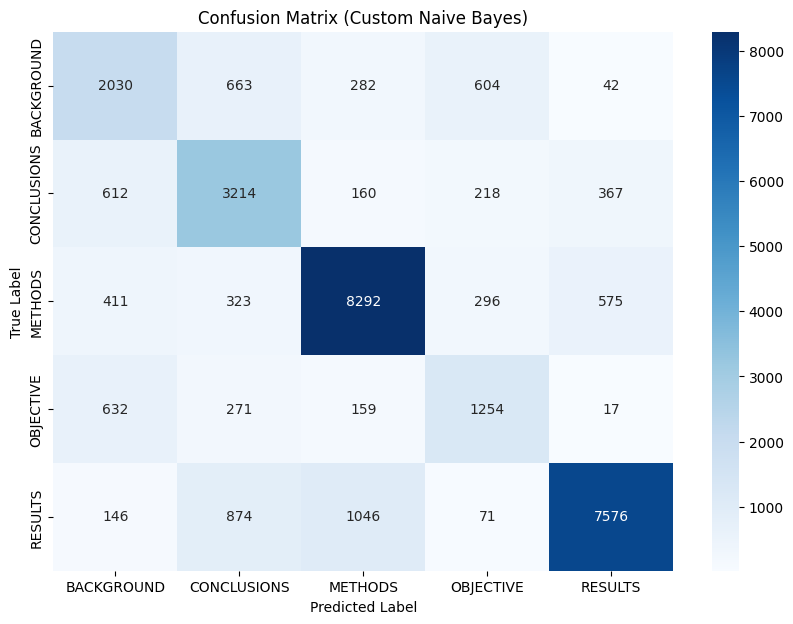

In [15]:
# Predict and evaluate on test set
print("\n=== Test Set Evaluation (Custom Count-Based Naive Bayes) ===")
# 7. Use the fitted nb_model to generate predictions
# // TODO: Predict y_test_pred using X_test_counts
if 'nb_model' in locals() and X_test_counts is not None:
    y_test_pred = nb_model.predict(X_test_counts)
else:
    y_test_pred = None

if y_test_pred is not None and len(y_test_pred) == len(y_test):
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"Macro-averaged F1 score: {test_f1:.4f}")

    # Confusion Matrix on test set
    # // TODO: Use the confusion_matrix, matplotlib, and seaborn libraries to generate
    # a visual confusion matrix (heatmap) for the predicted results.
    cm = confusion_matrix(y_test, y_test_pred, labels=target_names)
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=target_names,
        yticklabels=target_names
    )
    plt.title('Confusion Matrix (Custom Naive Bayes)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
else:
    print("Prediction step failed or incomplete.")

In [16]:
# **Part B**
# TF-IDF score based Classifier

# 1. Define a Pipeline
# // TODO: Define a Pipeline named 'pipeline' using TfidfVectorizer and MultinomialNB.
# Use standard initial parameters
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

# 2. Train the initial pipeline
# // TODO: Train the initial pipeline on the training set
print("Training initial Naive Bayes pipeline...")
if len(X_train) > 0:
    pipeline.fit(X_train, y_train)
    print("Training complete.")
else:
    print("Skipping initial pipeline training: Training data is empty.")

# 3. Predict and evaluate on test set
# // TODO: Predict y_test_pred and calculate metrics
print("\n=== Test Set Evaluation (Initial Sklearn Model) ===")
if len(X_test) > 0 and 'pipeline' in locals():
    y_test_pred_sklearn = pipeline.predict(X_test)

    if y_test_pred_sklearn is not None:
        print(f"Accuracy: {accuracy_score(y_test, y_test_pred_sklearn):.4f}")
        print(classification_report(y_test, y_test_pred_sklearn, target_names=target_names))
        print(f"Macro-averaged F1 score: {f1_score(y_test, y_test_pred_sklearn, average='macro'):.4f}")
    pass
else:
    print("Initial model evaluation skipped: Data not available or pipeline not trained.")

Training initial Naive Bayes pipeline...
Training complete.

=== Test Set Evaluation (Initial Sklearn Model) ===
Accuracy: 0.6996
              precision    recall  f1-score   support

  BACKGROUND       0.61      0.37      0.46      3621
 CONCLUSIONS       0.61      0.55      0.57      4571
     METHODS       0.68      0.88      0.77      9897
   OBJECTIVE       0.72      0.09      0.16      2333
     RESULTS       0.77      0.85      0.81      9713

    accuracy                           0.70     30135
   macro avg       0.68      0.55      0.56     30135
weighted avg       0.69      0.70      0.67     30135

Macro-averaged F1 score: 0.5555


In [17]:
# Hyperparameter Tuning using GridSearchCV

# 4. Define the parameter grid
# // TODO: Define the parameter grid 'param_grid' to tune both TF-IDF and NB parameters.
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)], # Tune unigrams (1,1) vs unigrams+bigrams (1,2)
    'nb__alpha': [0.1, 1.0, 10.0]           # Tune smoothing parameter
}

# 5. Initialize GridSearchCV
# // TODO: Initialize GridSearchCV using the pipeline and param_grid.
# Ensure cv=3 and scoring='f1_macro' are used.
if len(X_dev) > 0 and 'pipeline' in locals():
    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=3,
        scoring='f1_macro',
        verbose=1,
        n_jobs=-1
    )
    print("\nStarting Hyperparameter Tuning on Development Set...")

    # 6. Fit the Grid Search object
    # // TODO: Fit the GridSearchCV object using the development data.
    grid.fit(X_dev, y_dev)
    print("Grid search complete.")
else:
    grid = None
    print("Skipping hyperparameter tuning: Development data is empty or pipeline not initialized.")


if grid is not None and hasattr(grid, 'best_params_'):
    # 7. Print the best parameters and score
    # // TODO: Print the best parameters and the corresponding best cross-validation score.
    print(f"\nBest parameters found on development set: {grid.best_params_}")
    print(f"Best cross-validation macro F1 score: {grid.best_score_:.4f}")
    pass
else:
    print("Hyperparameter tuning skipped: Grid Search object not initialized or fitted.")


Starting Hyperparameter Tuning on Development Set...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Grid search complete.

Best parameters found on development set: {'nb__alpha': 0.1, 'tfidf__ngram_range': (1, 1)}
Best cross-validation macro F1 score: 0.5925


In [26]:
# **Part C**
# Bayes Optimal Classifier

# Dynamic Data Sampling (DO NOT CHANGE)
BASE_SAMPLE_SIZE = 10000
# Prompt the user for their full SRN
FULL_SRN = input("Please enter your full SRN (e.g., PES1UG22CS345): ")
try:
    # Extract the last three characters and convert to integer
    if len(FULL_SRN) >= 3:
        srn_suffix_str = FULL_SRN[-3:]
        srn_value = int(srn_suffix_str) # srn_value = 133
    else:
        raise ValueError("SRN too short.")
except (ValueError, IndexError, TypeError):
    print("WARNING: SRN input failed or format is incorrect. Using srn_value = 0.")
    srn_value = 0

# Calculate the final sample size: 10000 + last three SRN digits
SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value
print(f"Using dynamic sample size: {SAMPLE_SIZE}") # Should be 10133

# Data sampling is based on the SRN value
effective_sample_size = min(SAMPLE_SIZE, len(X_train))
X_train_sampled = X_train[:effective_sample_size]
y_train_sampled = y_train[:effective_sample_size]
print(f"Actual sampled training set size used: {effective_sample_size}")

# Base TF-IDF parameters (DO NOT CHANGE)
tfidf_params = {
    'lowercase': True,
    'strip_accents': 'unicode',
    'stop_words': 'english',
    'ngram_range': (1, 1), # Using unigrams only to keep feature space small for diverse models
    'min_df': 5
}
# Define the five diverse hypotheses/pipelines (DO NOT CHANGE)
h1_nb = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', MultinomialNB(alpha=1.0, fit_prior=False))
])
h2_lr = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42))
])
h3_rf = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1), cv=3, method='isotonic'
    ))
])
h4_dt = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        DecisionTreeClassifier(max_depth=10, random_state=42), cv=3, method='isotonic'
    ))
])
h5_knn = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        KNeighborsClassifier(n_neighbors=5, n_jobs=-1), cv=3, method='isotonic'
    ))
])
hypotheses = [h1_nb, h2_lr, h3_rf, h4_dt, h5_knn]
hypothesis_names = ['NaiveBayes', 'LogisticRegression', 'RandomForest', 'DecisionTree', 'KNN']

# 1. Train all five hypotheses on X_train_sampled and y_train_sampled
print("\nTraining all base models...")
for name, hypothesis in zip(hypothesis_names, hypotheses):
    print(f"  Training {name}...")
    hypothesis.fit(X_train_sampled, y_train_sampled)
print("All base models trained.")

Please enter your full SRN (e.g., PES1UG22CS345): pes2ug23cs133
Using dynamic sample size: 10133
Actual sampled training set size used: 10133

Training all base models...
  Training NaiveBayes...
  Training LogisticRegression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  Training RandomForest...
  Training DecisionTree...
  Training KNN...
All base models trained.


In [22]:
# 2. Compute the Posterior Weights P(h_i | D)

# Split the sampled training data into sub-training and validation set (30% for validation)
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_sampled, y_train_sampled, test_size=0.3, random_state=42, stratify=y_train_sampled
)

log_likelihoods = []
print("\nCalculating Posterior Weights (P(h_i | D)) on Validation Sub-set...")

for i, (name, hypothesis) in enumerate(zip(hypothesis_names, hypotheses)):
    # Retrain model on the sub-training set (to ensure the validation set is 'unseen')
    hypothesis.fit(X_train_sub, y_train_sub)

    # Predict probability P(y | x, h_i) on the validation set
    y_val_proba = hypothesis.predict_proba(X_val_sub)

    # Map class labels to column indices for the true labels
    # FIX: Get the final fitted step (MultinomialNB or CalibratedClassifierCV).
    # Both of these objects gain the classes_ attribute upon fitting.
    final_fitted_step = hypothesis.named_steps['clf']

    # Use the classes_ attribute from the final fitted step
    class_to_index = {label: i for i, label in enumerate(final_fitted_step.classes_)}
    true_class_indices = np.array([class_to_index[label] for label in y_val_sub])

    # Select the probability for the true class
    true_class_probas = y_val_proba[np.arange(len(y_val_sub)), true_class_indices]

    # Clip probabilities to avoid log(0)
    true_class_probas = np.clip(true_class_probas, 1e-15, 1)

    # Sum of log-probabilities is the total log-likelihood: L = sum(log P(y_i | x_i, h_i))
    log_L = np.sum(np.log(true_class_probas))
    log_likelihoods.append(log_L)
    print(f"  {name}: Log-Likelihood = {log_L:.2f}")

# Convert log-likelihoods to weights (proportional to Likelihood * Prior). Assume uniform prior.
log_likelihoods = np.array(log_likelihoods)
# Subtract the maximum log-likelihood for numerical stability
log_likelihoods -= np.max(log_likelihoods)
likelihoods = np.exp(log_likelihoods)

# Normalize likelihoods to get posterior weights that sum to 1
posterior_weights = likelihoods / np.sum(likelihoods)

print(f"\nCalculated Posterior Weights (sum={np.sum(posterior_weights):.4f}): {posterior_weights.round(4).tolist()}")


Calculating Posterior Weights (P(h_i | D)) on Validation Sub-set...
  NaiveBayes: Log-Likelihood = -2968.63


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  LogisticRegression: Log-Likelihood = -2758.10
  RandomForest: Log-Likelihood = -3045.38
  DecisionTree: Log-Likelihood = -3787.48
  KNN: Log-Likelihood = -4404.88

Calculated Posterior Weights (sum=1.0000): [0.0, 1.0, 0.0, 0.0, 0.0]



Fitting the VotingClassifier (BOC approximation)...
Fitting complete.

Predicting on test set...

=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===
Accuracy: 0.7079
Macro-averaged F1 score: 0.6133
              precision    recall  f1-score   support

  BACKGROUND       0.56      0.36      0.44      3621
 CONCLUSIONS       0.60      0.56      0.58      4571
     METHODS       0.71      0.89      0.79      9897
   OBJECTIVE       0.65      0.35      0.46      2333
     RESULTS       0.79      0.81      0.80      9713

    accuracy                           0.71     30135
   macro avg       0.66      0.59      0.61     30135
weighted avg       0.70      0.71      0.69     30135



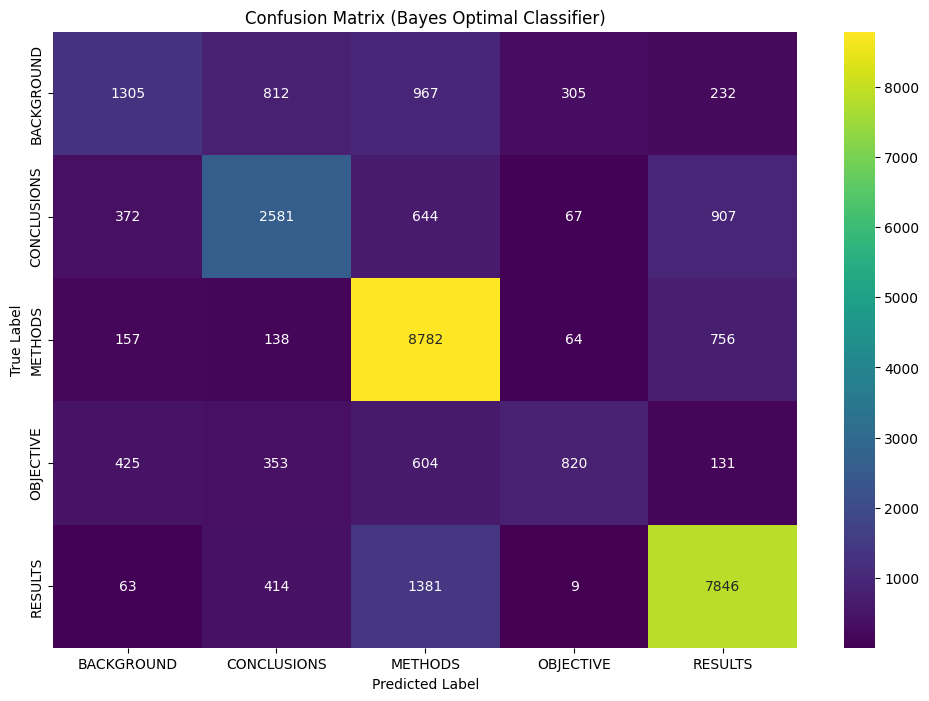

In [23]:
# Implement and Evaluate the Bayes Optimal Classifier
estimators = list(zip(hypothesis_names, hypotheses))

# BOC is approximated using soft voting with posterior weights
boc_soft_voter = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=posterior_weights,
    n_jobs=-1
)

print("\nFitting the VotingClassifier (BOC approximation)...")
# 3. Fit the VotingClassifier
# // TODO: Fit the VotingClassifier using the full sampled training data
boc_soft_voter.fit(X_train_sampled, y_train_sampled)
print("Fitting complete.")

# Make the final BOC prediction on the test set
print("\nPredicting on test set...")
# 4. Make final predictions and evaluate
# // TODO: Predict y_pred using X_test
if len(X_test) > 0 and 'boc_soft_voter' in locals():
    y_pred = boc_soft_voter.predict(X_test)
else:
    y_pred = None

# Final Evaluation
print("\n=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===")
if y_pred is not None and len(y_pred) == len(y_test):
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    test_f1 = f1_score(y_test, y_pred, average='macro')
    print(f"Macro-averaged F1 score: {test_f1:.4f}")
    print(classification_report(y_test, y_pred, target_names=target_names))

    # // TODO: Generate and visualize the Confusion Matrix (heatmap) for the BOC predictions.
    cm = confusion_matrix(y_test, y_pred, labels=target_names)
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='viridis',
        xticklabels=target_names,
        yticklabels=target_names
    )
    plt.title('Confusion Matrix (Bayes Optimal Classifier)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
else:
    print("Evaluation skipped: Predictions not generated.")